# Interaction Detection using GBM 
## Setup Jupyter Notebook

In [1]:
# !pip install pygam

### Import packages

In [4]:
import os 
import xgboost as xgb
import pandas as pd 
import numpy as np 
import random 
import pyarrow.parquet as pq
import sys
import shutil
import pickle
import warnings
from itertools import chain
import torch
from sklearn.metrics import mean_absolute_percentage_error
import graphviz

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization import matplotlib as optunampl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 260)
warnings.filterwarnings("ignore")

In [5]:
# Import the internal package
package_loc = r""

# Add the package location to system paths
sys.path.append(package_loc)

from src import utility

### Define Paths

In [6]:
###########################################################################
###########################################################################

wrk_dir = r""
product = "DB"
model_type = "GAM"
path = f"{wrk_dir}/{product}"
model_version = "v3"

###########################################################################
###########################################################################

# Define the directories for input and output
dir_input = f"{path}/Input"
dir_data = f"{path}/{model_type}/Export"
dir_output = (
    f"{path}/{model_type}/Output"
    if model_version == ""
    else f"{path}/{model_type}/Output/{model_version}"
)

print(os.listdir(dir_input))
print(os.listdir(dir_data))
print(os.listdir(dir_output))

['.amlignore', '.amlignore.amltmp', 'CMI Numerical Bands.xlsx', 'CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb']
['CMI DB Categorical Bands (with CalendarYear).xlsx', 'db_gam_modelling_data_v2.parquet']
['.ipynb_checkpoints', '02_model_note_db_gam_v3.xlsx', '03_model_note_db_gam_v3.xlsx', '04_model_note_db_gam_v3.xlsx', '05_model_note_db_gam_v3.xlsx', 'db_gam_initial_v3.pkl', 'db_gam_single_v3.pkl', 'ypred_single_factor_gam_v3.parquet']


### Set Variables

In [7]:
title_font = 25 
label_font = 20 
ticker_font = 15

## Create Modelling Data
### Load in the pruning progress

In [8]:
###########################################################################
###########################################################################

modelling_log_03 = f"03_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"
factors_tab = "Factors_Used"
pruning_tab = "Prune_Progress"

###########################################################################
###########################################################################

# Import the factor tracking tab
factorstracking_df = pd.read_excel(f"{dir_output}/{modelling_log_03}", factors_tab)
# Import the pruning progress tab
factor_prune_df = pd.read_excel(f"{dir_output}/{modelling_log_03}", pruning_tab)

In [9]:
###########################################################################
###########################################################################

# From the 04 notebook

num_factors = 5

###########################################################################
###########################################################################

# Define the final set of features used in the model 
iter_num = factor_prune_df.loc[factor_prune_df["num_factors"] == num_factors, "iter"].values[0]
final_feature = factorstracking_df.iloc[5]
final_feature = final_feature.dropna().tolist()

# Include calandar year if not already in the final features - important for Covid
if "CalendarYear_cat_level" not in final_feature: 
    final_feature += ["CalendarYear_cat_level"]
print(final_feature)

['Age_level', 'SmokerStatus_cat_level', 'Duration_level', 'Gender_cat_level', 'SumAssuredBand_level', 'CalendarYear_cat_level']


### Import modelling data

In [ ]:
###########################################################################
###########################################################################

data_version = "v2"
model_data_file = f"db_gam_modelling_data_{data_version}.parquet"

###########################################################################
###########################################################################

model_data = pd.read_parquet(f"{dir_data}/{model_data_file}")
model_data

In [11]:
###########################################################################
###########################################################################

claim_count = "IncurredClaims"
claim_freq = "AnnualFreq"
weight = "LivesExposure"

# Define the list of categorical features
cat_feat = [x for x in final_feature if "_cat_level" in x]

# Define the list of numerical features
num_feat = [x for x in final_feature if x not in cat_feat]

###########################################################################
###########################################################################

# Define the target for GAM
model_data[claim_freq] = model_data[claim_count] / model_data[weight]

print(f"List of categorical features    : {cat_feat}")
print(f"List of numerical features      : {num_feat}")

List of categorical features    : ['SmokerStatus_cat_level', 'Gender_cat_level', 'CalendarYear_cat_level']
List of numerical features      : ['Age_level', 'Duration_level', 'SumAssuredBand_level']


In [ ]:
# Need to remove rows with 0 exposures
model_data = model_data[
    ~(
        (model_data[claim_freq].isnull())
        | (model_data[claim_freq] == np.inf)
    )
]
model_data

In [13]:
# Count null values for all columns
model_data.isnull().sum()

ProductCategory                  0
Gender                           0
SmokerStatus                     0
DistributionChannel              0
CommencementYear                 0
JointLifeStatus                  0
SumAssuredBand                   0
Age                              0
Duration                         0
LivesExposure                    0
AmountsExposure                  0
IncurredClaims                   0
AmountIncurred                   0
ExpectedClaims                   0
ExpectedAmountClaims             0
ComparatorTable                  0
CalendarYear                     0
holdout                          0
random_fold                      0
CommencementYear_level           0
SumAssuredBand_level             0
Age_level                        0
Duration_level                   0
ProductCategory_cat_level        0
Gender_cat_level                 0
SmokerStatus_cat_level           0
DistributionChannel_cat_level    0
JointLifeStatus_cat_level        0
CalendarYear_cat_lev

### Join single-factor predictions as starting points

In [ ]:
###########################################################################
###########################################################################

ypred_filename = f"ypred_single_factor_gam_{model_version}.parquet"
new_model_count = "gam_claim_count"

###########################################################################
###########################################################################

# Import the single-factor predictions 
ypred_df = pd.read_parquet(f"{dir_output}/{ypred_filename}")

# Join GAM-predicted claim count onto the main dataframe
model_data = model_data.join(ypred_df[new_model_count]) 
model_data

### Encode categorical variables

In [15]:
cat_feat_encoded = []
cat_feat_encoded_all = []
cat_feat_raw = [x.replace("_cat_level", "") for x in cat_feat]

for var in cat_feat_raw: 
    if len(model_data[var].unique()) > 2: 
        cat_feat_encoded.append(var + "_cat_level")
        for level in model_data[var].unique(): 
            model_data[f"{var}.{str(level)}"] = np.where(
                model_data[var] == level, 1, 0
            )
            cat_feat_encoded_all.append(f"{var}.{str(level)}")

print(cat_feat_encoded)
print(cat_feat_encoded_all)

['CalendarYear_cat_level']
['CalendarYear.CY2016', 'CalendarYear.CY2017', 'CalendarYear.CY2018', 'CalendarYear.CY2019', 'CalendarYear.CY2020']


In [16]:
# Define the final factor list used in GBM
final_feature_gbm = (
    num_feat + [x for x in cat_feat if x not in cat_feat_encoded] + cat_feat_encoded_all
)
print(final_feature_gbm)

['Age_level', 'Duration_level', 'SumAssuredBand_level', 'SmokerStatus_cat_level', 'Gender_cat_level', 'CalendarYear.CY2016', 'CalendarYear.CY2017', 'CalendarYear.CY2018', 'CalendarYear.CY2019', 'CalendarYear.CY2020']


### Downsample of 0s in the training data

In [ ]:
###########################################################################
###########################################################################

holdout = "holdout"

# Define the sample size of data with no claims 
sample_size = 1500000
random_seed = 653

###########################################################################
###########################################################################

train0 = model_data[(model_data[claim_freq] == 0) & (model_data[holdout] == 0)]
train1 = model_data[(model_data[claim_freq] > 0) & (model_data[holdout] == 0)]

# Generate a list of random numbers without replacement
random.seed(random_seed)
random_numbers = random.sample(
    list(range(len(train0))), len(train0)
)

# Define a random sample that consists of a down-sample of 0 and all the rows with claims
index0 = random_numbers[:sample_size]
train0_rs = train0.iloc[index0]
train_rs = pd.concat([train0_rs, train1], axis=0)
train_rs

In [18]:
# Calculate the actual frequency in the sample vs the one in the full training data
cf_rs = train_rs[claim_count].sum() / train_rs[weight].sum()

cf = (
    model_data[model_data[holdout] == 0][claim_count].sum()
    / model_data[model_data[holdout] == 0][weight].sum()
)

print(f"Actual Freq in the down-sample: {cf_rs:.4%}")
print(f"Actual Freq in the full training data: {cf:.4%}")

Actual Freq in the down-sample: 0.1696%
Actual Freq in the full training data: 0.1314%


In [19]:
# Calculate the base adjustment required to to applied to the model outputs
base_adj = cf / cf_rs
print(f"Base Adjustment: {base_adj:.4f}")

Base Adjustment: 0.7744


### Define required dataframes

In [20]:
###########################################################################
###########################################################################

holdout = "holdout"
random_fold = "random_fold"
num_fold = 5  # Number of folds in the training data

###########################################################################
###########################################################################
X_train_rs = train_rs[final_feature_gbm]
y_train_rs = train_rs[claim_count]
start_train_rs = train_rs[new_model_count]

X_test = model_data.loc[model_data[holdout] == 1, final_feature_gbm]
y_test = model_data.loc[model_data[holdout] == 1, claim_count]
start_test = (
    model_data.loc[model_data[holdout] == 1, new_model_count] * base_adj
)

# Define the cross-validation folds required for hyperparameter tuning
random_fold_values = train_rs[random_fold].values

# Define a list of tuples, each first element contains indices for the training fold and each second element contains indices for the holdout
folds = []
df_ = pd.DataFrame(
    zip(range(len(random_fold_values)), random_fold_values),
    columns=["row_index", random_fold],
)

for i in range(num_fold):
    index_train = df_[df_[random_fold] != i + 1]["row_index"].to_list()
    index_valid = df_[df_[random_fold] == i + 1]["row_index"].to_list()
    folds.append((index_train, index_valid))

valid_folds = [k[1] for k in folds]
check = np.sort(np.array(list(chain(*valid_folds)))) == np.arange(len(X_train_rs))

assert check.sum() == len(
    X_train_rs
), "Not all the rows in the training data are included in the data folds."

In [21]:
# Define the data matrices for XGB training 
dtrain = xgb.DMatrix(
    data=X_train_rs,
    label=y_train_rs, 
    base_margin=np.log(start_train_rs),
)
dtest = xgb.DMatrix(
    data=X_test, 
    label=y_test, 
    base_margin=np.log(start_test)
)

## XGB Training 
### Hyperparameter Tuning  using Optuna

In [22]:
###########################################################################
###########################################################################

has_cuda = torch.cuda.is_available()
eta = 0.02 
tree_method = "gpu_hist" if has_cuda else "hist"
xgb_objective = "count:poisson"
metric = "poisson-nloglik"
seed = 1997
num_boost_round = 10000 
early_stopping_round = 30
n_trials = 50

###########################################################################
###########################################################################

print(tree_method)

gpu_hist


In [23]:
# Define an objective function for Optuna 
def objective(trial): 
    params = {
        "eta": eta, 
        "min_child_weight": trial.suggest_int(
            "min_child_weight", 1, 1e3, log=True
        ),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 1e-6, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 2),
        "tree_method": tree_method, 
        "objective": xgb_objective,
        "eval_metric": metric,
        "seed": seed,
    }

    xgb_cv = xgb.cv(
        dtrain=dtrain, 
        params=params, 
        seed=seed, 
        num_boost_round=num_boost_round, 
        metrics=metric, 
        early_stopping_rounds=early_stopping_round, 
        folds=folds,
    )
    return xgb_cv[f"test-{metric}-mean"].min()

In [45]:
study = optuna.create_study(direction="minimize")

[I 2025-01-12 11:21:37,408] A new study created in memory with name: no-name-fe64efc0-cfcd-4a78-b818-f4ab4c403c60


In [46]:
study.optimize(objective, n_trials=n_trials)

[I 2025-01-12 11:22:13,909] Trial 0 finished with value: 0.08643034448340138 and parameters: {'min_child_weight': 2, 'colsample_bytree': 0.861932689907617, 'colsample_bylevel': 0.9908537496999626, 'subsample': 0.9057887729255606, 'gamma': 0.3370809853526049, 'max_depth': 2}. Best is trial 0 with value: 0.08643034448340138.
[I 2025-01-12 11:23:05,425] Trial 1 finished with value: 0.0864308279888539 and parameters: {'min_child_weight': 831, 'colsample_bytree': 0.7272607163922261, 'colsample_bylevel': 0.5614177805933738, 'subsample': 0.6930253621189146, 'gamma': 1.4955792060651218e-05, 'max_depth': 2}. Best is trial 0 with value: 0.08643034448340138.
[I 2025-01-12 11:23:41,283] Trial 2 finished with value: 0.08643376765958602 and parameters: {'min_child_weight': 2, 'colsample_bytree': 0.6856761112963179, 'colsample_bylevel': 0.8660721835369958, 'subsample': 0.5838188472083918, 'gamma': 0.007732453298978419, 'max_depth': 2}. Best is trial 0 with value: 0.08643034448340138.
[I 2025-01-12 11

[I 2025-01-12 11:36:59,761] Trial 25 finished with value: 0.08642431236723196 and parameters: {'min_child_weight': 76, 'colsample_bytree': 0.8833972076158597, 'colsample_bylevel': 0.613502356026585, 'subsample': 0.9037521840165352, 'gamma': 0.0031269579340319808, 'max_depth': 2}. Best is trial 24 with value: 0.0864201183429947.
[I 2025-01-12 11:37:36,996] Trial 26 finished with value: 0.08642354203409852 and parameters: {'min_child_weight': 5, 'colsample_bytree': 0.9603187077849555, 'colsample_bylevel': 0.6816118326076938, 'subsample': 0.8783410305553632, 'gamma': 0.0004612461603829523, 'max_depth': 2}. Best is trial 24 with value: 0.0864201183429947.
[I 2025-01-12 11:38:20,721] Trial 27 finished with value: 0.08642818264852897 and parameters: {'min_child_weight': 27, 'colsample_bytree': 0.8178636043579368, 'colsample_bylevel': 0.5031208153607367, 'subsample': 0.959659352919476, 'gamma': 0.02774341995155248, 'max_depth': 2}. Best is trial 24 with value: 0.0864201183429947.
[I 2025-01-1

In [47]:
# Print best trial
best_trial_number = study.best_trial.number
best_trial_value = study.best_trial.value
print(f"Best trial: {best_trial_number} with value {best_trial_value}\n{'*'*80}")

# Print out the best parameters
best_hyperparams = study.best_params
print(best_hyperparams)

Best trial: 24 with value 0.0864201183429947
********************************************************************************
{'min_child_weight': 43, 'colsample_bytree': 0.9930783989757314, 'colsample_bylevel': 0.6811349991936589, 'subsample': 0.847850286384966, 'gamma': 0.0003906196095655035, 'max_depth': 2}


In [ ]:
###########################################################################
###########################################################################

modelling_log = f"05_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="w"
) as writer:
    study.trials_dataframe().sort_values("value").to_excel(
        writer, sheet_name="XGB_Tune", index=False
    )

shutil.copyfile(
    f"/tmp/{modelling_log}",
    f"{dir_output}/{modelling_log}",
)

<AxesSubplot: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

<Figure size 1000x600 with 0 Axes>

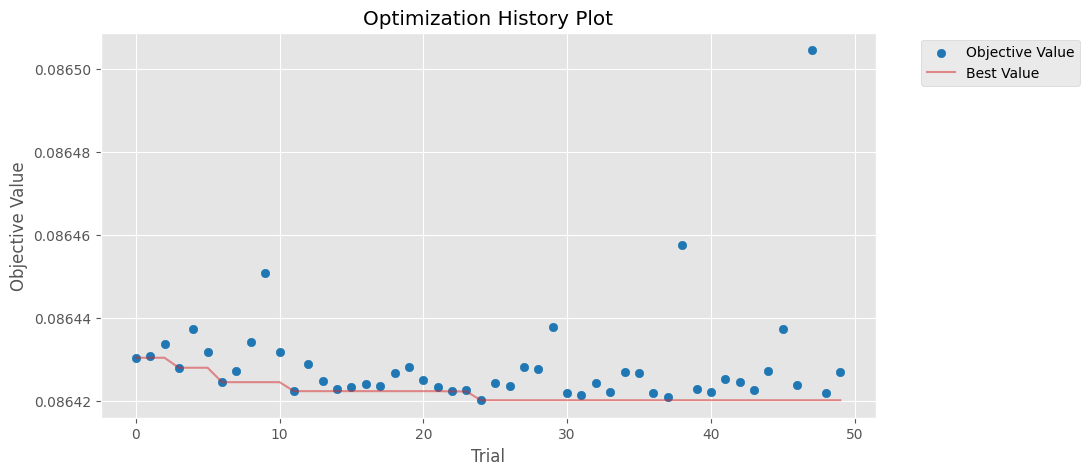

<Figure size 1000x500 with 0 Axes>

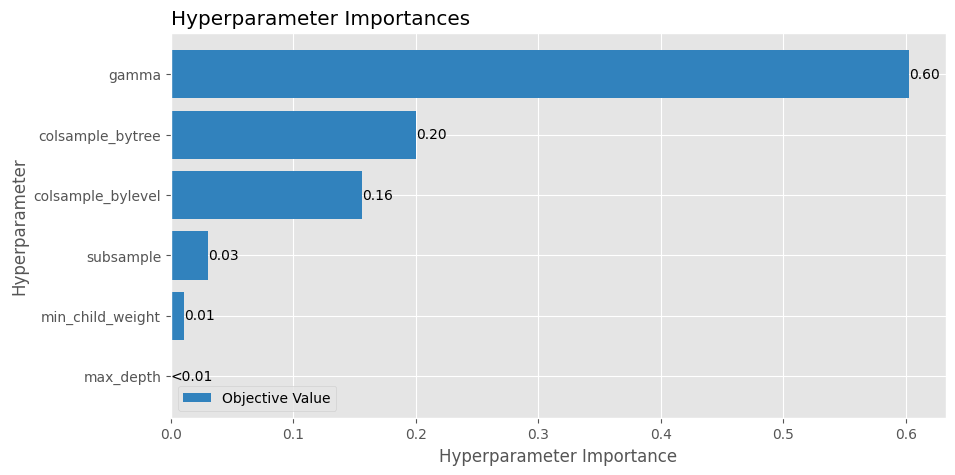

<Figure size 1000x500 with 0 Axes>

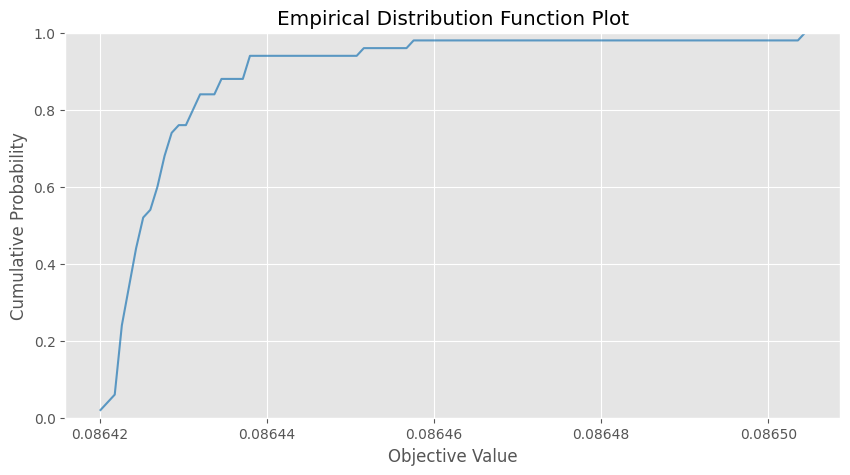

In [49]:
plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_optimization_history(study)

plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_param_importances(study) # Plot parameter importance

plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_edf(study) # Plot the empirical cumulative distribution plot

[W 2025-01-12 11:51:25,357] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([<AxesSubplot: xlabel='colsample_bylevel', ylabel='Objective Value'>,
       <AxesSubplot: xlabel='colsample_bytree'>,
       <AxesSubplot: xlabel='gamma'>], dtype=object)

<Figure size 1000x500 with 0 Axes>

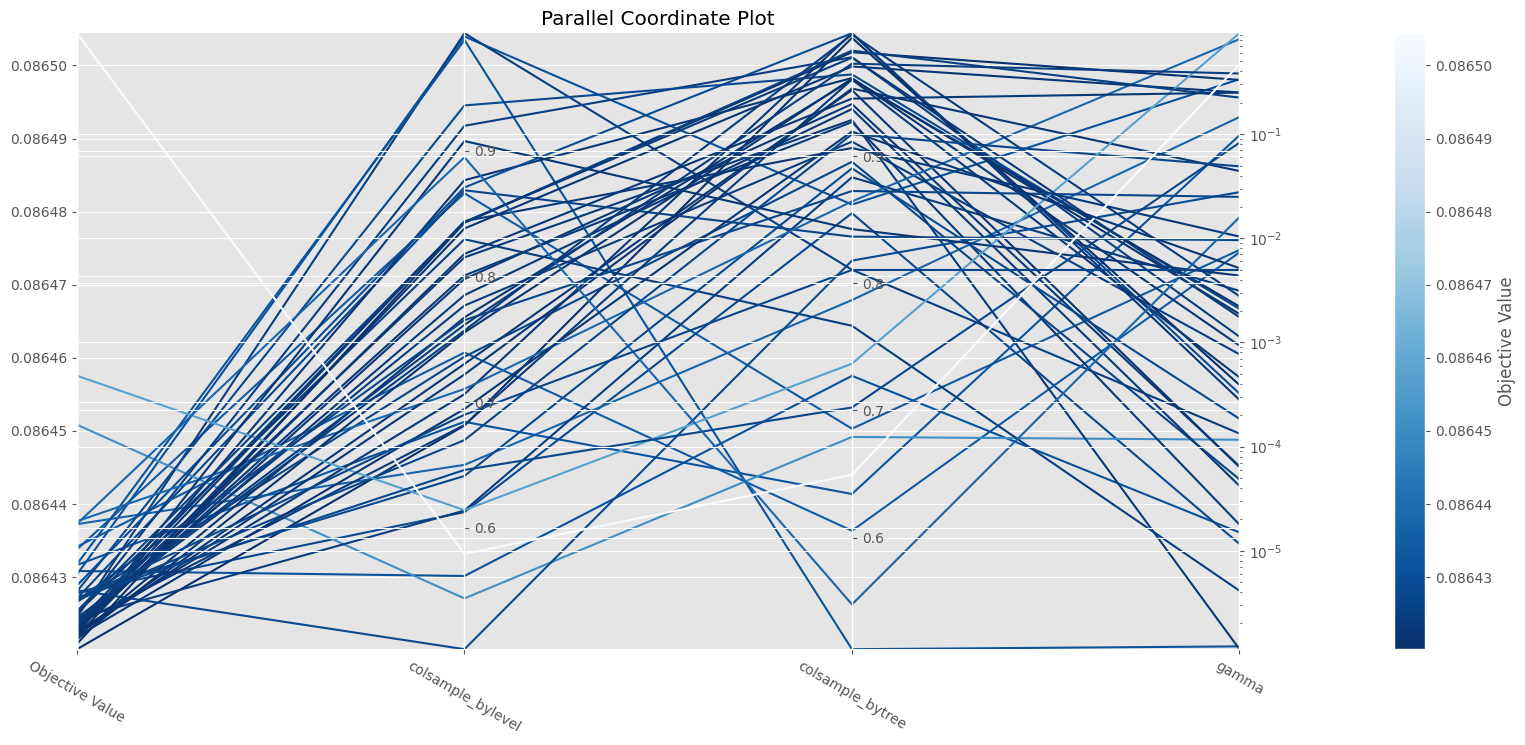

<Figure size 2000x800 with 0 Axes>

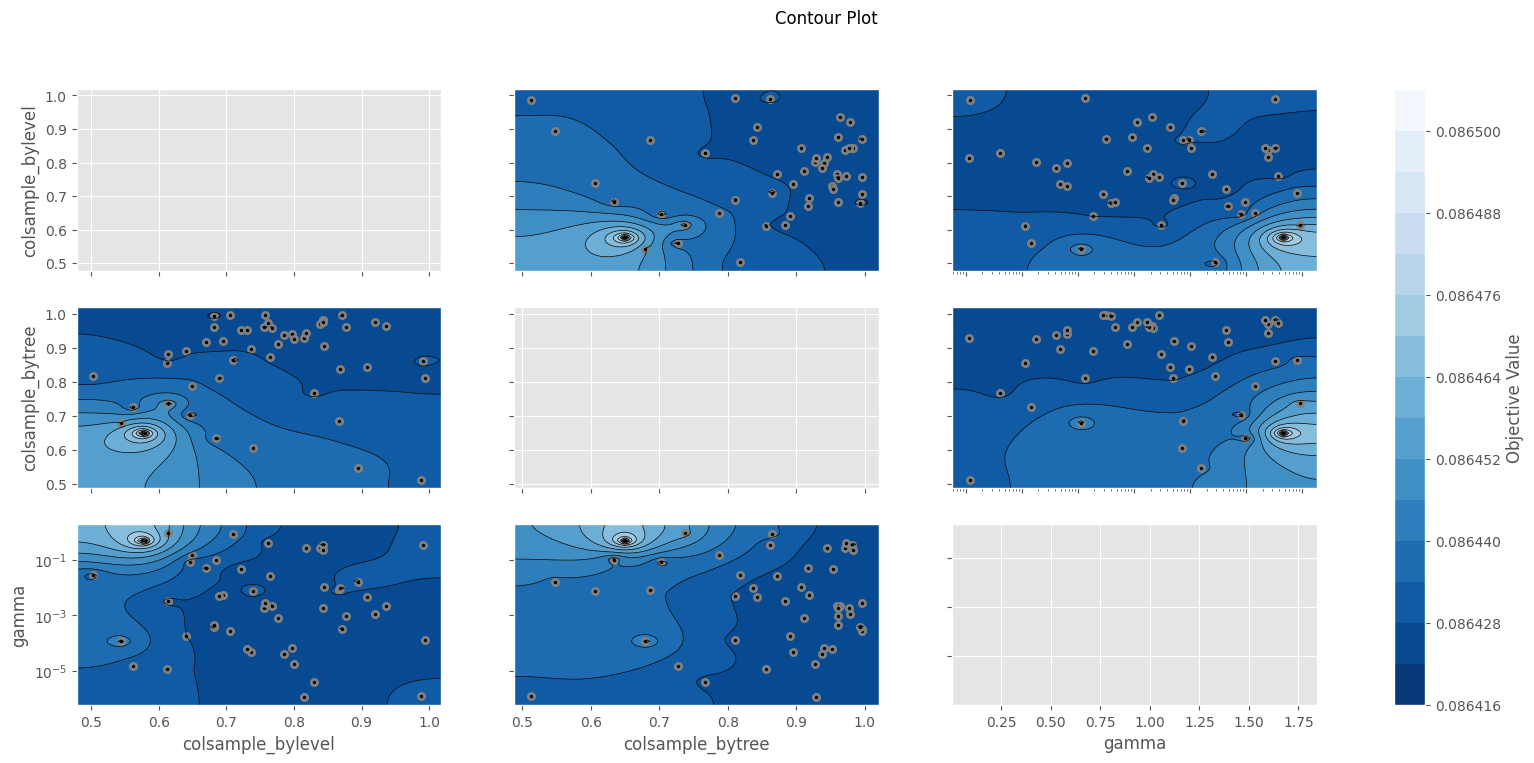

<Figure size 2000x800 with 0 Axes>

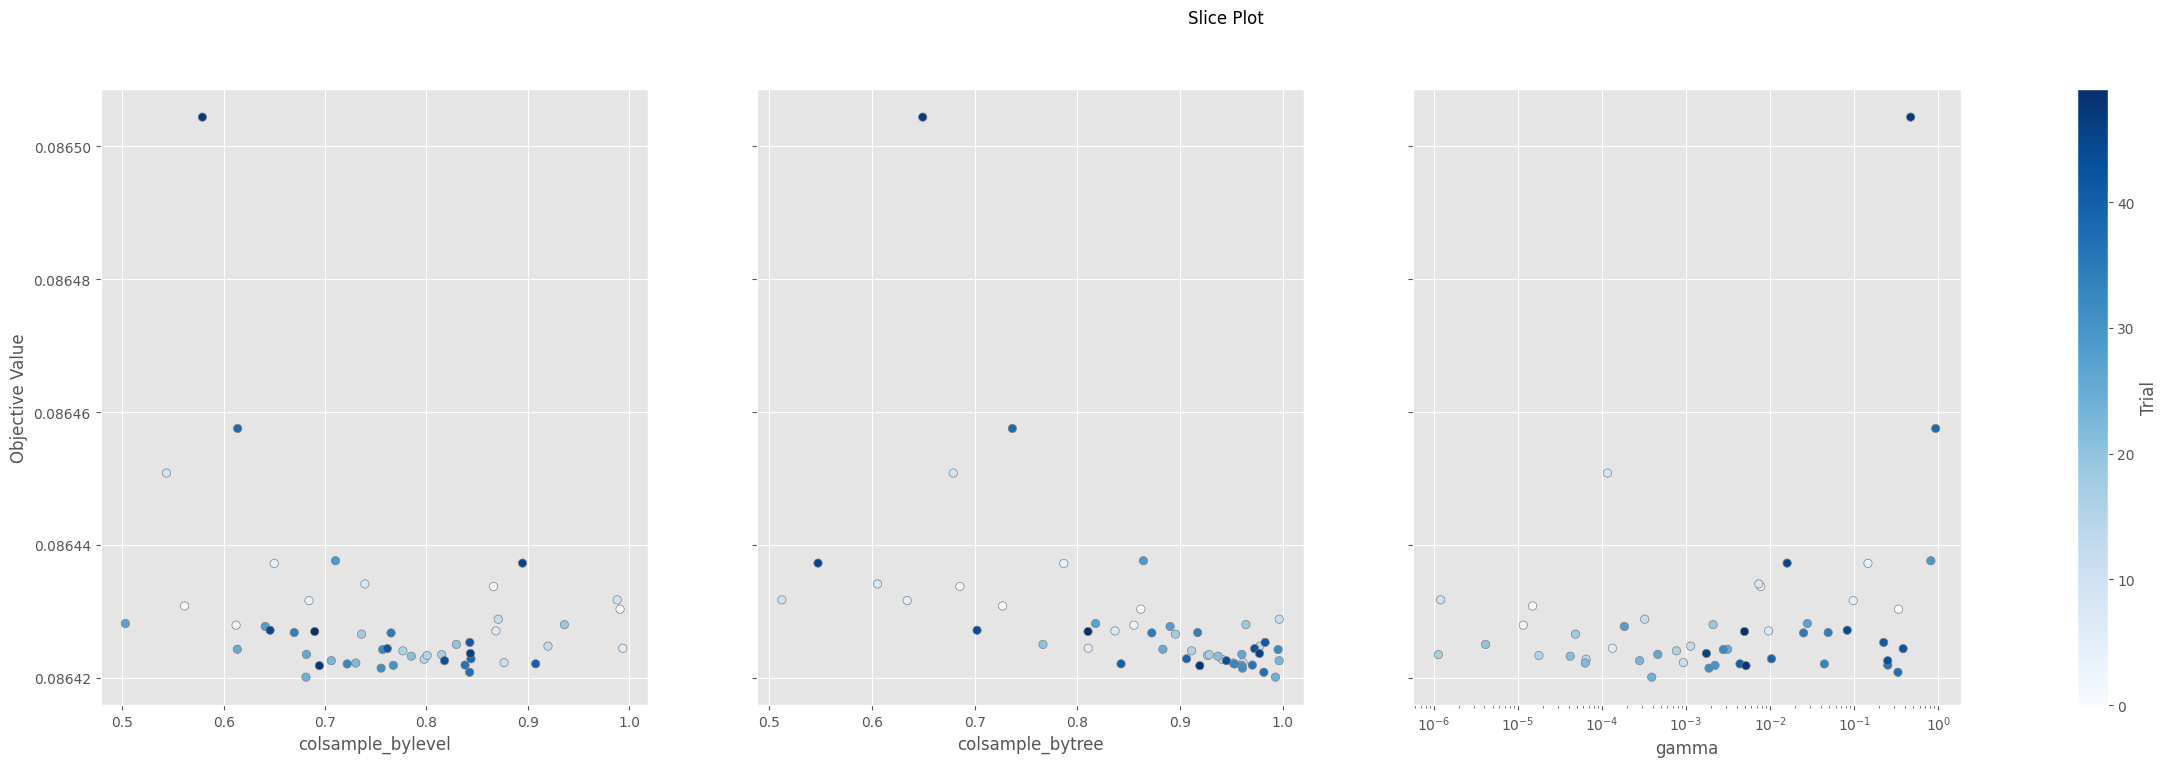

In [50]:
param_importance = optuna.importance.get_param_importances(study)

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_parallel_coordinate(study, params=list(param_importance)[:3])

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_contour(study, params=list(param_importance)[:3])

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_slice(study, params=list(param_importance)[:3])

### Tune # trees

In [24]:
###########################################################################
###########################################################################

modelling_log = f"05_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

study_df = pd.read_excel(f"{dir_output}/{modelling_log}", "XGB_Tune")
best_params = study_df.sort_values("value").filter(regex="params_").iloc[0].to_dict()
best_params = {k.replace("params_", ""): v for k, v in best_params.items()}
best_params["max_depth"] = int(best_params["max_depth"])
print(best_params)

{'colsample_bylevel': 0.6811349991936589, 'colsample_bytree': 0.9930783989757314, 'gamma': 0.0003906196095655035, 'max_depth': 2, 'min_child_weight': 43.0, 'subsample': 0.847850286384966}


In [25]:
###########################################################################
###########################################################################

all_params = {
    "eta": eta, 
    "tree_method": tree_method, 
    "objective": xgb_objective,
    "eval_metric": metric,
    "seed": seed,
    **best_params
}

verbose = 100

###########################################################################
###########################################################################

xgb_cv = xgb.cv(
    dtrain=dtrain, 
    params=all_params, 
    seed=seed, 
    num_boost_round=num_boost_round, 
    metrics=metric, 
    early_stopping_rounds=early_stopping_round, 
    folds=folds,
    verbose_eval=verbose,
)

[0]	train-poisson-nloglik:0.08651+0.00026	test-poisson-nloglik:0.08651+0.00104
[100]	train-poisson-nloglik:0.08649+0.00026	test-poisson-nloglik:0.08650+0.00103
[200]	train-poisson-nloglik:0.08647+0.00026	test-poisson-nloglik:0.08649+0.00103
[300]	train-poisson-nloglik:0.08645+0.00026	test-poisson-nloglik:0.08648+0.00103
[400]	train-poisson-nloglik:0.08644+0.00026	test-poisson-nloglik:0.08647+0.00103
[500]	train-poisson-nloglik:0.08643+0.00026	test-poisson-nloglik:0.08646+0.00103
[600]	train-poisson-nloglik:0.08642+0.00026	test-poisson-nloglik:0.08645+0.00103
[700]	train-poisson-nloglik:0.08641+0.00026	test-poisson-nloglik:0.08645+0.00103
[800]	train-poisson-nloglik:0.08640+0.00026	test-poisson-nloglik:0.08644+0.00103
[900]	train-poisson-nloglik:0.08639+0.00026	test-poisson-nloglik:0.08644+0.00103
[1000]	train-poisson-nloglik:0.08639+0.00026	test-poisson-nloglik:0.08644+0.00103
[1100]	train-poisson-nloglik:0.08638+0.00026	test-poisson-nloglik:0.08643+0.00103
[1200]	train-poisson-nloglik

Text(0.5, 1.0, 'Cross-Validaeted Deviance Loss by Number of Trees')

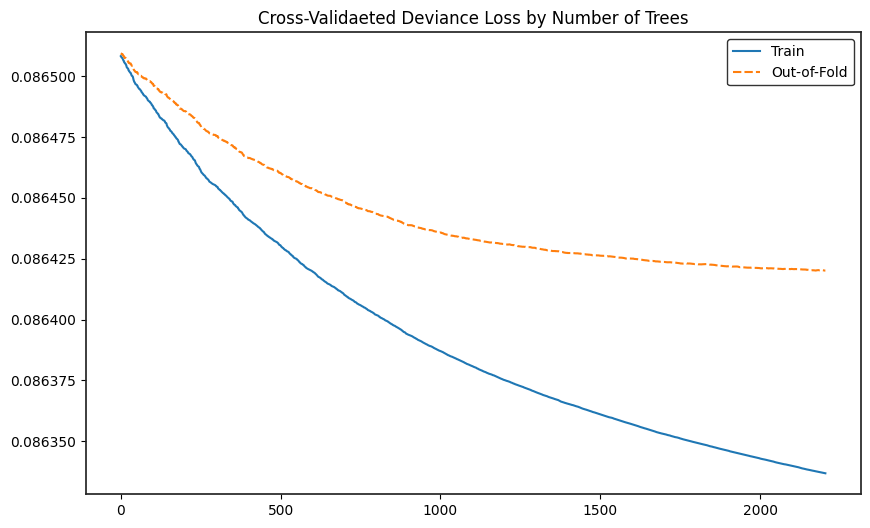

In [26]:
xgb_cv.rename(
    columns={f"train-{metric}-mean": "Train", f"test-{metric}-mean": "Out-of-Fold"}, 
    inplace=True,
)

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["figure.figsize"] = [10, 6]

fig, ax = plt.subplots(1)

sns.lineplot(
    data=xgb_cv[["Train", "Out-of-Fold"]], 
    ax=ax, 
)

ax.grid(False)
ax.set_facecolor("white")

ax.legend(facecolor="white", edgecolor="black")
ax.set_title(f"Cross-Validaeted Deviance Loss by Number of Trees")

## Train the XGB model

In [27]:
best_iteration = len(xgb_cv)

bst = xgb.train(all_params, dtrain, best_iteration)

### Feature importance

In [87]:
###########################################################################
###########################################################################

importance_type = "total_gain"

###########################################################################
###########################################################################

xgb_imp_df = pd.DataFrame( 
    bst.get_score(importance_type=importance_type).items(), 
    columns=["Feature", "Importance"]
)

# Clean up the feature name
xgb_imp_df["Feature_Agg"] = (
    xgb_imp_df["Feature"].str.split(".").str[0]
)
xgb_imp_df["Feature_Agg"] = (
    xgb_imp_df["Feature_Agg"]
    .str.replace("_cat_level", "")
    .str.replace("_level", "")
)

# Aggregate the importance dataframe 
xgb_imp_df_agg = (
    xgb_imp_df.groupby(
        ["Feature_Agg"], as_index=False
    )[["Importance"]].sum()
)
xgb_imp_df_agg.sort_values("Importance", inplace=True, ascending=False)

xgb_imp_df_agg["Importance_Norm"] = (
    xgb_imp_df_agg["Importance"] / xgb_imp_df_agg["Importance"].sum()
)
xgb_imp_df_agg

,Feature_Agg,Importance,Importance_Norm
0,Age,4567.788574,0.366205
4,SmokerStatus,4053.553711,0.324978
3,Gender,1192.419556,0.095598
2,Duration,1159.322632,0.092944
5,SumAssuredBand,877.465942,0.070347
1,CalendarYear,622.766487,0.049928


Text(0.5, 1.0, 'XGB Factor Importance')

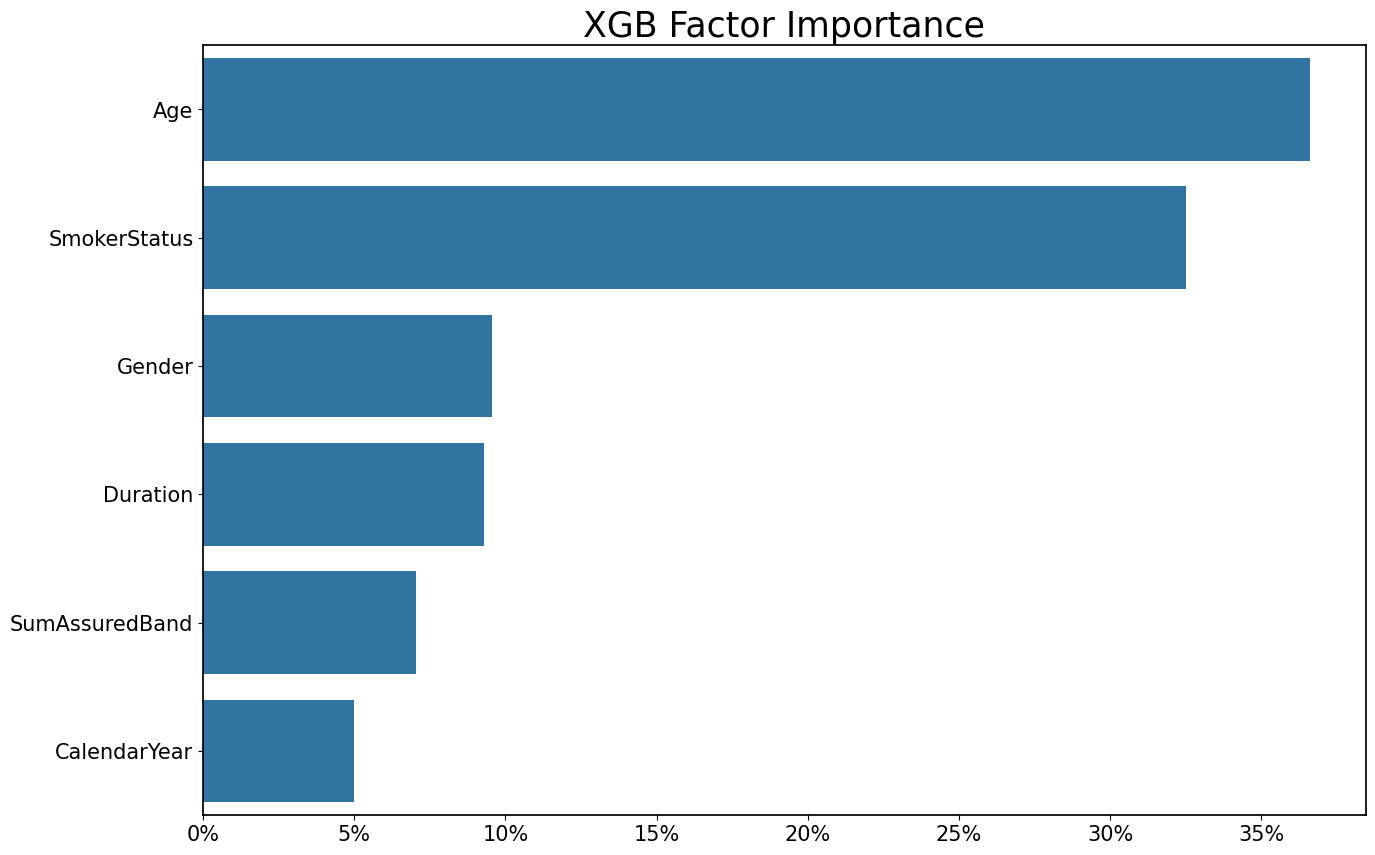

In [88]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.edgecolor"] = "black"

fig, ax = plt.subplots(1)

sns.barplot(
    data=xgb_imp_df_agg, 
    y="Feature_Agg", 
    x="Importance_Norm", 
    color="tab:blue", 
    ax=ax,
)

# Do some formating in the x and y axes to make them easier to read
xticker = ax.get_xticks() 
xlabel = [f'{x:,.0%}' for x in xticker]
ax.set_xticklabels(xlabel, fontsize=ticker_font)

ylabel = xgb_imp_df_agg["Feature_Agg"] 
ax.set_yticklabels(ylabel, fontsize=ticker_font)

ax.set_facecolor("white")

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title("XGB Factor Importance", fontsize=title_font)

### Holdout Model Performance

In [ ]:
####################################################################
####################################################################

xgb_count = "ypred_xgb"

####################################################################
####################################################################

ypred_test = bst.predict(dtest)
ypred_test_df = pd.DataFrame(
    ypred_test, columns=[xgb_count], index=X_test.index
)
ypred_test_df = (
    ypred_test_df.join(start_test).join(y_test).join(model_data[weight])
)
ypred_test_df

In [90]:
gam_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count], 
    y_pred=ypred_test_df[new_model_count],
)
xgb_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count], 
    y_pred=ypred_test_df[xgb_count],
)

print(f"{'GAM (Single-Factor)':<20}: {gam_dev:,.0f}")
print(f"{'XGBoost':<20}: {xgb_dev:,.0f}")

GAM (Single-Factor) : 52,929
XGBoost             : 52,834


In [91]:
predict = [new_model_count, xgb_count]

d = utility.DoubleLift(
    ypred_test_df, predict, claim_count, weight, [0.02, 0.98], approx_num_band=25
)

mape_gam = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[new_model_count],
    sample_weight=d.double_lift_table[weight],
)
mape_xgb = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[xgb_count],
    sample_weight=d.double_lift_table[weight],
)
print(f"{'MAPE - GAM (Single Factor)':<28}: {mape_gam:.2%}")
print(f"{'MAPE - XGBoost':<28}: {mape_xgb:.2%}")

MAPE - GAM (Single Factor)  : 9.90%
MAPE - XGBoost              : 3.01%


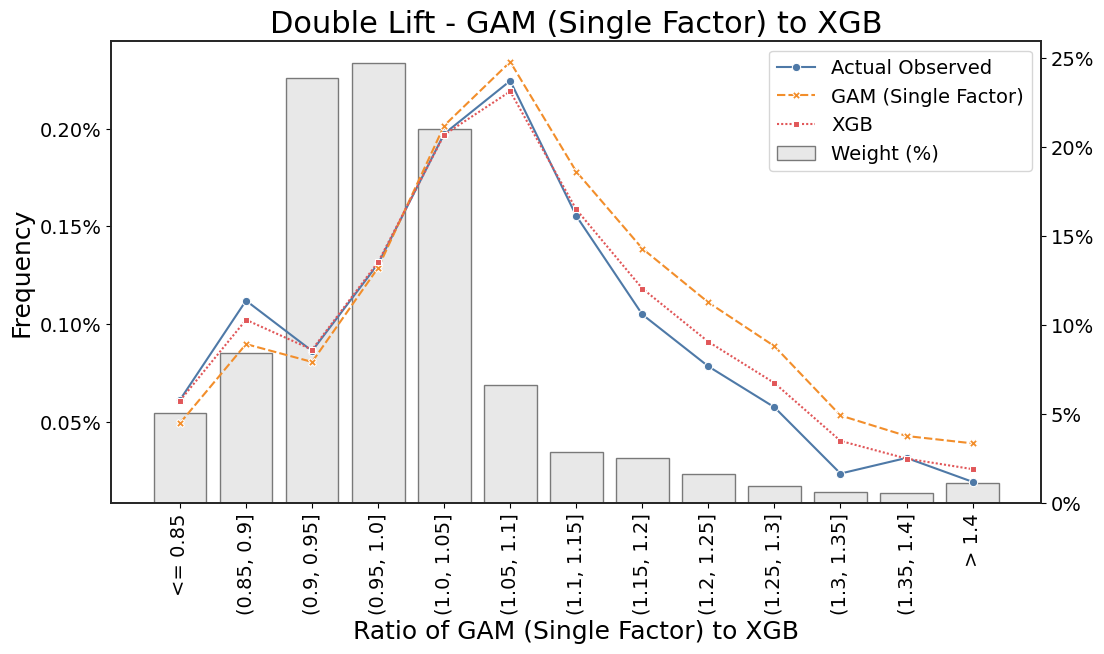

In [92]:
###########################################################################
###########################################################################

param_dict = {
    "title": "Double Lift - GAM (Single Factor) to XGB", 
    "leftylabel": "Frequency", 
    "rightylabel": "Weight (%)",
    "target_legend": "Actual Observed", 
    "new_model_legend": "GAM (Single Factor)",
    "baseline_legend": "XGB",
}

###########################################################################
###########################################################################

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

fig, ax = plt.subplots(figsize=(12, 6))

d.plot_double_lift(ax=ax, **param_dict)

## Derive interaction importance

<AxesSubplot: >

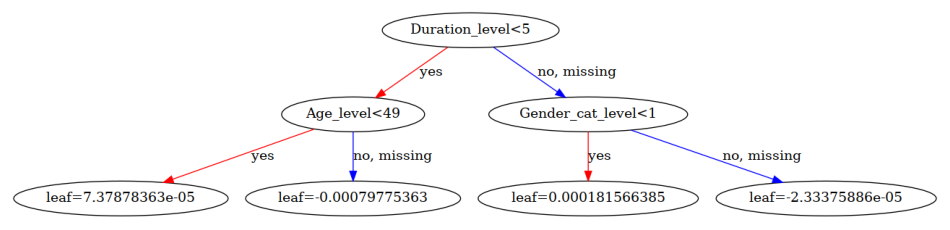

In [93]:
# Plot one tree to visualise it
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_tree(bst, num_trees=1999, ax=ax)

In [94]:
# Get the node details
node_df = bst.trees_to_dataframe()

# Clean up the feature name
node_df["Feature"] = (
    node_df["Feature"].str.split(".").str[0]
)
node_df["Feature"] = (
    node_df["Feature"]
    .str.replace("_cat_level", "")
    .str.replace("_level", "")
)
node_df

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,Age,8.0,0-1,0-2,0-2,2.451455,65147.058600,NaN
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,0.004672,43.538738,NaN
2,0,2,0-2,Age,36.0,0-3,0-4,0-4,1.327178,65103.519500,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.000114,19901.132800,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,-0.000082,45202.386700,NaN
...,...,...,...,...,...,...,...,...,...,...,...
15068,2204,2,2204-2,Duration,9.0,2204-5,2204-6,2204-6,0.388361,63626.929700,NaN
15069,2204,3,2204-3,Leaf,NaN,NaN,NaN,NaN,-0.000465,1364.001100,NaN
15070,2204,4,2204-4,Leaf,NaN,NaN,NaN,NaN,0.002110,90.716019,NaN
15071,2204,5,2204-5,Leaf,NaN,NaN,NaN,NaN,0.000048,29956.869100,NaN


In [95]:
# Get the parent node for every tree 
node_df_0 = node_df[node_df.Node == 0]

# Join the features used to split in the next level (Yes)
node_df_0_Y = node_df_0.merge(
    node_df[["ID", "Feature", "Gain"]], 
    left_on="Yes", 
    right_on="ID", 
    suffixes=("", "1"),
)
node_df_0_Y = node_df_0_Y[
    node_df_0_Y["Feature1"] != "Leaf"
]
node_df_0_Y = node_df_0_Y[
    node_df_0_Y["Feature"] != node_df_0_Y["Feature1"]
]
node_df_0_Y["Feature_List"] = (
    node_df_0_Y.apply(lambda x: np.sort([x.Feature, x.Feature1]), axis=1)
)
node_df_0_Y = node_df_0_Y[["Feature_List", "Gain1"]]
print(node_df_0_Y.head())

# Join the features used to split in the next level (No)
node_df_0_N = node_df_0.merge(
    node_df[["ID", "Feature", "Gain"]], 
    left_on="No", 
    right_on="ID", 
    suffixes=("", "1"),
)
node_df_0_N = node_df_0_N[
    node_df_0_N["Feature1"] != "Leaf"
]
node_df_0_N = node_df_0_N[
    node_df_0_N["Feature"] != node_df_0_N["Feature1"]
]
node_df_0_N["Feature_List"] = (
    node_df_0_N.apply(lambda x: np.sort([x.Feature, x.Feature1]), axis=1)
)
node_df_0_N = node_df_0_N[["Feature_List", "Gain1"]]
print(node_df_0_N.head())

                     Feature_List      Gain1
1              [Duration, Gender]   6.247215
2  [SmokerStatus, SumAssuredBand]  16.158445
4           [Age, SumAssuredBand]   2.969204
5              [Duration, Gender]  13.703813
7  [SmokerStatus, SumAssuredBand]  15.584861
                     Feature_List     Gain1
1              [Duration, Gender]  1.768061
2  [SmokerStatus, SumAssuredBand]  5.044297
4           [Age, SumAssuredBand]  3.079095
5              [Duration, Gender]  1.080007
6                 [Age, Duration]  0.419663


In [102]:
# Aggregate Gains to two-way interactions 
two_way_gain_df = pd.concat([node_df_0_Y, node_df_0_N], axis=0)
two_way_gain_df["Feature_List"] = two_way_gain_df["Feature_List"].apply(
    lambda x: " x ".join(x)
)
two_way_gain_df = two_way_gain_df.groupby(
    ["Feature_List"], as_index=False
)[["Gain1"]].sum()
two_way_gain_df = two_way_gain_df.sort_values("Gain1", ascending=False)
two_way_gain_df["Gain_Norm"] = (
    two_way_gain_df["Gain1"] / two_way_gain_df["Gain1"].sum()
)

Text(0.5, 1.0, 'Interaction Importance')

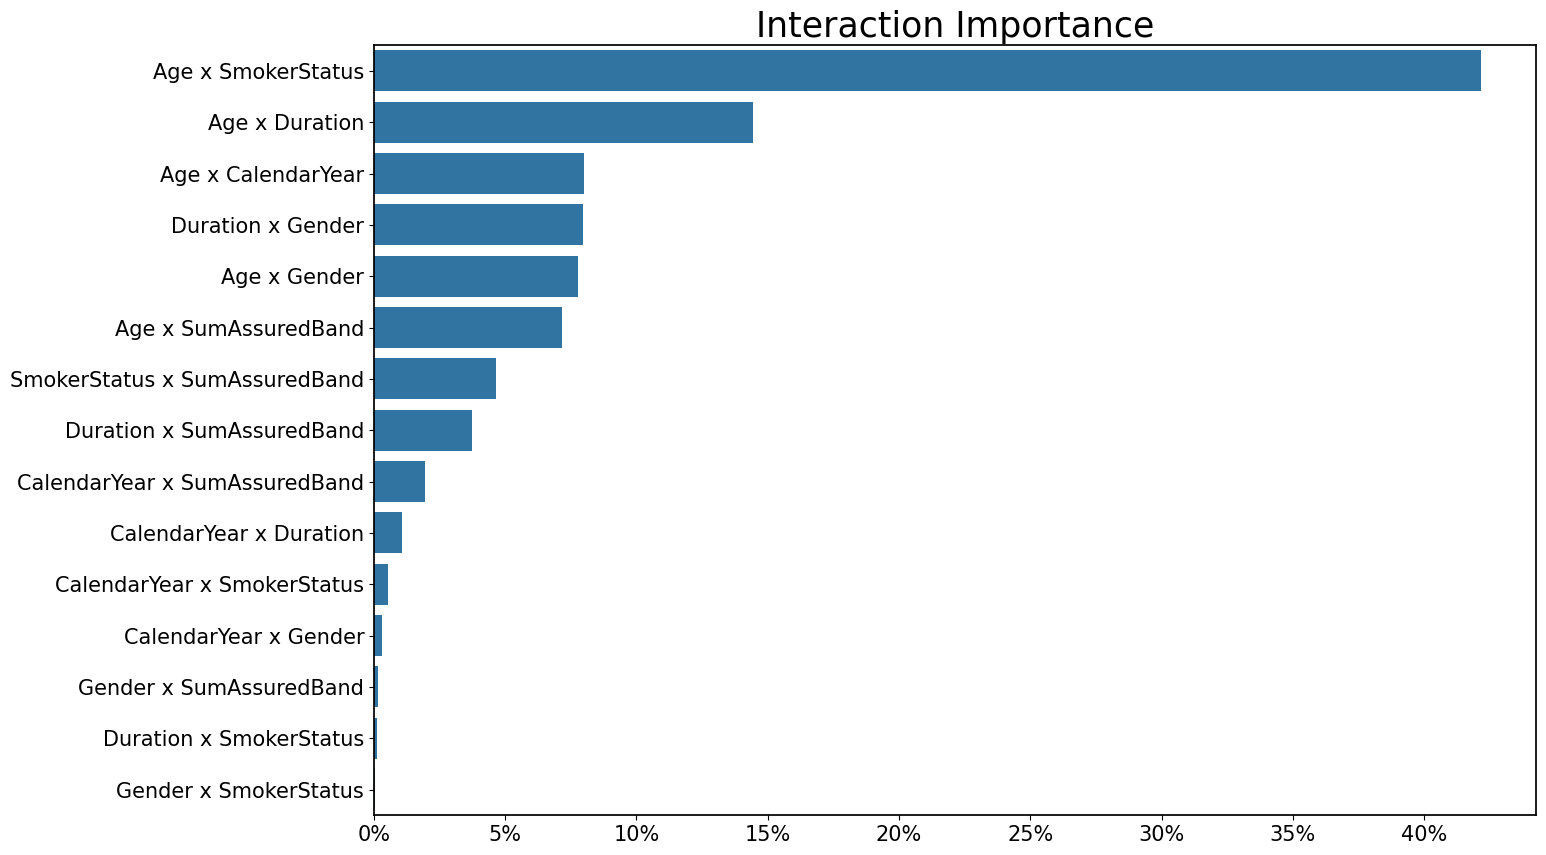

In [103]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.edgecolor"] = "black"

fig, ax = plt.subplots(1)

sns.barplot(
    data=two_way_gain_df, 
    y="Feature_List", 
    x="Gain_Norm", 
    color="tab:blue", 
    ax=ax,
)

# Do some formating in the x and y axes to make them easier to read
xticker = ax.get_xticks() 
xlabel = [f'{x:,.0%}' for x in xticker]
ax.set_xticklabels(xlabel, fontsize=ticker_font)

ylabel = two_way_gain_df["Feature_List"] 
ax.set_yticklabels(ylabel, fontsize=ticker_font)

ax.set_facecolor("white")

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title("Interaction Importance", fontsize=title_font)

In [ ]:
with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="a", if_sheet_exists="replace"
) as writer:
    two_way_gain_df.to_excel(
        writer, sheet_name="Inter_Imp_GBM", index=False
    )

shutil.copyfile(
    f"/tmp/{modelling_log}",
    f"{dir_output}/{modelling_log}",
)